# NLP - CA6
* **Name:** Mohammad Mahdi Salmani
* **Student id:** 810102174

## Load libraries

In [ ]:
%pip install -r requirements.txt

In [1]:
import os
import json
import requests
from tqdm import tqdm
from bs4 import BeautifulSoup
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.storage import LocalFileStore
from dotenv import load_dotenv
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_together import ChatTogether
from langchain.retrievers import EnsembleRetriever
from langchain_community.retrievers import BM25Retriever
from langchain_community.vectorstores import FAISS
from langchain.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import Literal
from operator import itemgetter
from IPython.core.display import Markdown
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.documents.base import Document
from langchain_core.prompts import PromptTemplate
from langchain.output_parsers import PydanticOutputParser
from langchain.embeddings import CacheBackedEmbeddings
from langchain.utilities.tavily_search import TavilySearchAPIWrapper
from langchain.tools.tavily_search import TavilySearchResults
from tavily import TavilyClient

## Part1: Load dataset

In [2]:
with open("configs.json") as f:
    configs = json.loads(f.read())

os.environ["TAVILY_API_KEY"] = configs["api"]["TAVILY_API_KEY"]
os.environ["TOGETHER_API_KEY"] = configs["api"]["TOGETHER_API_KEY"]

### Crawl pdf list from site

In [17]:
url = "https://stanford.edu/~jurafsky/slp3/"

response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

chapters = []
for link in soup.find_all('a', href=True):
    if '.pdf' in link['href'] and link['href'].split('.')[0].isdigit():
        chapters.append(link['href'])

pdf_links = [url+link for link in chapters]
pdf_links

['https://stanford.edu/~jurafsky/slp3/2.pdf',
 'https://stanford.edu/~jurafsky/slp3/3.pdf',
 'https://stanford.edu/~jurafsky/slp3/4.pdf',
 'https://stanford.edu/~jurafsky/slp3/5.pdf',
 'https://stanford.edu/~jurafsky/slp3/6.pdf',
 'https://stanford.edu/~jurafsky/slp3/7.pdf',
 'https://stanford.edu/~jurafsky/slp3/8.pdf',
 'https://stanford.edu/~jurafsky/slp3/9.pdf',
 'https://stanford.edu/~jurafsky/slp3/10.pdf',
 'https://stanford.edu/~jurafsky/slp3/11.pdf',
 'https://stanford.edu/~jurafsky/slp3/13.pdf',
 'https://stanford.edu/~jurafsky/slp3/14.pdf',
 'https://stanford.edu/~jurafsky/slp3/15.pdf',
 'https://stanford.edu/~jurafsky/slp3/16.pdf',
 'https://stanford.edu/~jurafsky/slp3/17.pdf',
 'https://stanford.edu/~jurafsky/slp3/18.pdf',
 'https://stanford.edu/~jurafsky/slp3/19.pdf',
 'https://stanford.edu/~jurafsky/slp3/20.pdf',
 'https://stanford.edu/~jurafsky/slp3/21.pdf',
 'https://stanford.edu/~jurafsky/slp3/22.pdf',
 'https://stanford.edu/~jurafsky/slp3/23.pdf']

### Download PDFs

In [18]:
selected_pdf_links = pdf_links[:10] # Just retrieve from Chapter I: Fundamental Algorithms

In [19]:
documents = []
for pdf_link in tqdm(selected_pdf_links):
    loader = PyPDFLoader(pdf_link)
    documents.extend(loader.load())

100%|██████████| 10/10 [07:15<00:00, 43.52s/it]


In [20]:
len(documents)

275

### Chunking

In [21]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=64)
chunks = text_splitter.split_documents(documents)

len(chunks)

904

### Vector Store

In [19]:
%pip install --upgrade --quiet  langchain-openai faiss-cpu

Note: you may need to restart the kernel to use updated packages.


In [ ]:
embedding_function = HuggingFaceEmbeddings(show_progress=True, multi_process=True)

In [23]:
store = LocalFileStore("./embedding_cache/")
cached_embedder = CacheBackedEmbeddings.from_bytes_store(embedding_function, store, namespace=embedding_function.model_name)

## Part3: Retriever

In [30]:
# %%time
vector_store = FAISS.from_documents(documents=chunks, embedding=cached_embedder)

CPU times: total: 203 ms
Wall time: 2min 34s


In [24]:
# %%time
vector_store = FAISS.from_documents(documents=chunks, embedding=cached_embedder)

In [57]:
query = "Recurrent Neural Networks"
results = vector_store.similarity_search_with_relevance_scores(query, k=3)

for i, result in enumerate(results):
    print(f'[{i+1}] Score: {result[1]:.3f}, Metadata: {result[0].metadata}')
    print(f'\n{result[0].page_content[:200]}...\n')

[1] Score: 0.589, Metadata: {'source': 'https://stanford.edu/~jurafsky/slp3/9.pdf', 'page': 0}

the prior context, in its recurrent connections , allowing the model’s decision to
depend on information from hundreds of words in the past. We’ll see how to apply
the model to the task of language mo...

[2] Score: 0.562, Metadata: {'source': 'https://stanford.edu/~jurafsky/slp3/9.pdf', 'page': 23}

covered:
• In simple Recurrent Neural Networks sequences are processed one element at
a time, with the output of each neural unit at time tbased both on the current
input at tand the hidden layer from...

[3] Score: 0.553, Metadata: {'source': 'https://stanford.edu/~jurafsky/slp3/9.pdf', 'page': 26}

neural networks. SemEval-2016 .
Gers, F. A., J. Schmidhuber, and F. Cummins. 2000. Learn-
ing to forget: Continual prediction with lstm. Neural
computation , 12(10):2451–2471.
Giles, C. L., G. M. Kuhn...



In [25]:
sample_queries = [
    "What is the advantage of Bidirectional RNNs?",
    "What is the differences between a stack and a queue.",
    "Who is the president of United States?"
]

In [60]:
faiss_retriever = vector_store.as_retriever(search_kwargs={"k": 3})

for i, question in enumerate(sample_queries):
    print(f'[Q{i+1}] {question}\n')
    results = faiss_retriever.invoke(query)
    for j, result in enumerate(results):
        print(f'Retrieve {j+1}) {result.metadata}')
        print(f'\n{result.page_content[:200]}...\n')

[Q1] What is the advantage of Bidirectional RNNs?

Retrieve 1) {'source': 'https://stanford.edu/~jurafsky/slp3/9.pdf', 'page': 0}

the prior context, in its recurrent connections , allowing the model’s decision to
depend on information from hundreds of words in the past. We’ll see how to apply
the model to the task of language mo...

Retrieve 2) {'source': 'https://stanford.edu/~jurafsky/slp3/9.pdf', 'page': 23}

covered:
• In simple Recurrent Neural Networks sequences are processed one element at
a time, with the output of each neural unit at time tbased both on the current
input at tand the hidden layer from...

Retrieve 3) {'source': 'https://stanford.edu/~jurafsky/slp3/9.pdf', 'page': 26}

neural networks. SemEval-2016 .
Gers, F. A., J. Schmidhuber, and F. Cummins. 2000. Learn-
ing to forget: Continual prediction with lstm. Neural
computation , 12(10):2451–2471.
Giles, C. L., G. M. Kuhn...

[Q2] What is the differences between a stack and a queue.

Retrieve 1) {'source': 'https://s

## Part3: EnsembleRetriever

In [ ]:
%pip install --upgrade --quiet  rank_bm25

In [26]:
bm25_retriever = BM25Retriever.from_documents(documents=chunks, embedding=cached_embedder)

In [30]:
ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, faiss_retriever], weights=[0.3, 0.7]
)

In [33]:
ensemble_retriever.invoke(sample_queries[0])

[Document(page_content='sequence from tto the end of the sequence.\nAbidirectional RNN (Schuster and Paliwal, 1997) combines two independentbidirectional\nRNN\nRNNs, one where the input is processed from the start to the end, and the other from\nthe end to the start. We then concatenate the two representations computed by the\nnetworks into a single vector that captures both the left and right contexts of an input\nat each point in time. Here we use either the semicolon ”;” or the equivalent symbol\n⊕to mean vector concatenation:\nht= [hf\nt;hb\nt]\n=hf\nt⊕hb\nt (9.18)\nFig. 9.11 illustrates such a bidirectional network that concatenates the outputs of\nthe forward and backward pass. Other simple ways to combine the forward and\nbackward contexts include element-wise addition or multiplication. The output at\neach step in time thus captures information to the left and to the right of the current\ninput. In sequence labeling applications, these concatenated outputs can serve as the\nbas

In [39]:
bm25_retriever.k = 2
faiss_retriever.search_kwargs = {"k": 2}

[0.3, 0.7]

In [36]:
ensemble_retriever.invoke(sample_queries[0])

[Document(page_content='sequence from tto the end of the sequence.\nAbidirectional RNN (Schuster and Paliwal, 1997) combines two independentbidirectional\nRNN\nRNNs, one where the input is processed from the start to the end, and the other from\nthe end to the start. We then concatenate the two representations computed by the\nnetworks into a single vector that captures both the left and right contexts of an input\nat each point in time. Here we use either the semicolon ”;” or the equivalent symbol\n⊕to mean vector concatenation:\nht= [hf\nt;hb\nt]\n=hf\nt⊕hb\nt (9.18)\nFig. 9.11 illustrates such a bidirectional network that concatenates the outputs of\nthe forward and backward pass. Other simple ways to combine the forward and\nbackward contexts include element-wise addition or multiplication. The output at\neach step in time thus captures information to the left and to the right of the current\ninput. In sequence labeling applications, these concatenated outputs can serve as the\nbas

## Part4: Router Chain

In [3]:
llm = ChatTogether(
    model="meta-llama/Llama-3-70b-chat-hf",
    temperature= 0,
    )

In [55]:
router_prompt = ChatPromptTemplate.from_template(
    template="""
You are a routing assistant responsible for directing user queries to the appropriate tool: either a VectorStore, SearchEngine, or a fallback message.
Your VectorStore contains data about chapters of the Natural Language Processing book by Jurafsky. If the given query is about N-grams, Text Classifications, Embeddings, Sequence Labeling, RNNs, LSTMs, Transformers, or Large Language Models, choose VectorStore.
If the query is related to general computer science topics, choose SearchEngine.
If the query is not related to NLP or computer science, choose None.

Decide whether the given question should be routed to "VectorStore", "SearchEngine", or "None".
Provide only the name of the chosen tool and nothing else. If no tool is chosen, return the string "None".

{output_instructions}

Query: {query}

Response: """,
)

In [56]:
class ChosenTool(BaseModel):
    tool_name: Literal["VectorStore", "SearchEngine", "None"] = Field(description="the tool that was chosen by LLM in question routing stage")

question_router_parser = PydanticOutputParser(pydantic_object=ChosenTool)

In [57]:
router_chain = router_prompt | llm | question_router_parser

## Part5: Search Engine Chain

### Tavily Search Sample

In [98]:
from langchain.agents import initialize_agent, AgentType

search = TavilySearchAPIWrapper()
tavily_tool = TavilySearchResults(api_wrapper=search)

agent_chain = initialize_agent(
    [tavily_tool],
    llm,
    agent=AgentType.STRUCTURED_CHAT_ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
)

agent_chain.run("Who is the president of Iran?")



> Entering new AgentExecutor chain...
Question: Who is the president of Iran?
Thought: I need to look up the current president of Iran.
Action:
```
{
  "action": "tavily_search_results_json",
  "action_input": "current president of Iran"
}
```

Observation: [{'url': 'https://abcnews.go.com/International/wireStory/masoud-pezeshkian-heart-surgeon-rose-power-parliament-now-111709850', 'content': 'The stances of Iran\'s President-elect Masoud Pezeshkian reflect the dualities of being a reformist politician within Iran’s Shiite theocracy DUBAI, United Arab Emirates -- After the 2022 death of Mahsa Amini, Iranian lawmaker Masoud Pezeshkian wrote that it was “unacceptable in the Islamic Republic to arrest a girl for her hijab Trending Reader Picks 12-year-old attacked and taken by crocodile Would Harris be a stronger candidate than Biden? How to escape from life-threatening rip currents 4 people injured by shark in Gulf on July 4 Parents at beach with kids die in rip current ABC News Live 2

'The current president of Iran is Masoud Pezeshkian.'

In [ ]:
%pip install tavily-python

In [104]:
client = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])
client.search("Who is the president of Iran?", search_depth="advanced")

{'query': 'Who is the president of Iran?',
 'follow_up_questions': None,
 'answer': None,
 'images': None,
 'results': [{'url': 'https://en.wikipedia.org/wiki/President_of_Iran',
   'title': 'President of Iran - Wikipedia',
   'content': "Powers and responsibilities[edit]\nThe President's duties include the following, subject to supervision and approval by the Supreme Leader:\nsome of these duties require the approval of the Supreme Leader.[28]\nOath of office[edit]\nI, as the President, upon the Holy Qur'an and in the presence of the Iranian nation, do hereby swear in the name of Almighty God to safeguard the official Faith, the system of the Islamic republic and the Constitution of the country; to use all my talents and abilities in the discharge of responsibilities undertaken by me; to devote myself to the service of the people, glory of the country, promotion of religion and morality, support of right and propagation of justice; to refrain from being autocratic; to protect the free

### Implement Search Engine Chain

In [8]:
class SearchEngineChain:
    def __init__(self, api_key):
        self.client = TavilyClient(api_key=api_key)

    def __call__(self, query: str):
        results = self.search_tavily(query)
        documents = self.process_results(results)
        return documents

    def search_tavily(self, query: str):
        response = self.client.search(query, search_depth="advanced")
        return response["results"]

    def process_results(self, results: list[dict]):
        documents = []
        for result in results[:5]:  # حداکثر 5 نتیجه
            content = result.get("content")
            url = result.get("url")
            document = Document(page_content=content, metadata={"url": url}) #TODO: source
            documents.append(document)
        return documents
    
    def invoke(self, input: str):
        return self.__call__(query=input)

search_engine_chain = SearchEngineChain(api_key=os.environ['TAVILY_API_KEY'])

In [116]:
query = "Who is the president of Iran?"
result = search_engine_chain.invoke(query)
result

[Document(page_content="Powers and responsibilities[edit]\nThe President's duties include the following, subject to supervision and approval by the Supreme Leader:\nsome of these duties require the approval of the Supreme Leader.[28]\nOath of office[edit]\nI, as the President, upon the Holy Qur'an and in the presence of the Iranian nation, do hereby swear in the name of Almighty God to safeguard the official Faith, the system of the Islamic republic and the Constitution of the country; to use all my talents and abilities in the discharge of responsibilities undertaken by me; to devote myself to the service of the people, glory of the country, promotion of religion and morality, support of right and propagation of justice; to refrain from being autocratic; to protect the freedom and dignity of individuals and the rights of the Nation recognized by the Constitution; to spare no efforts in safeguarding the frontiers and the political, economic and cultural freedoms of the country; to guar

## Part6: Relevancy Check Chain

In [9]:
relevancy_check_prompt = ChatPromptTemplate.from_template(
    template="""
You are given a user query and a document. Your task is to evaluate if the document is relevant to the query.
Respond with only one word: "relevant" or "irrelevant".

{output_instructions}

Query: {query}

Document: {document}

Response: """
)

class Relevance(BaseModel):
    relevance: Literal["relevant", "irrelevant"]

relevance_parser = PydanticOutputParser(pydantic_object=Relevance)

relevancy_check_chain = relevancy_check_prompt | llm | relevance_parser

## Part7: Fallback Chain

In [10]:
fallback_prompt = ChatPromptTemplate.from_template(
    """
You are a helpful assistant created by the LLM Group at the Tehran University.
Please do not respond to queries outside the scope of Natural Language Processing or Computer Science.
If a query is outside these domains, kindly inform the user of your limitations.
Provide clear and concise responses only to queries within these topics.

Current conversation history:

{chat_history}

human: {query}
"""
)

generative_llm = ChatTogether(
    model="meta-llama/Llama-3-70b-chat-hf",
    temperature= 0.7,
    )

fallback_chain = (
    {
        "chat_history": lambda x: "\n".join(
            [
                (
                    f"human: {msg.content}"
                    if isinstance(msg, HumanMessage)
                    else f"AI: {msg.content}"
                )
                for msg in x["chat_history"]
            ]
        ),
        "query": itemgetter("query"),
    }
    | fallback_prompt
    | generative_llm
    | StrOutputParser()
)

In [125]:
response = fallback_chain.invoke( # using discriminative llm
    {
        "query": "Hello, What's up?",
        "chat_history": [],
    }
)
print(response)

Hello! I'm doing well, thanks for asking. I'm here to assist you with any questions or topics related to Natural Language Processing (NLP) or Computer Science. What would you like to discuss or ask about?


In [127]:
response = fallback_chain.invoke( # using generative llm
    {
        "query": "Hello, What's up?",
        "chat_history": [],
    }
)
print(response)

Hello! As a helpful assistant, I'm here to assist you with any questions or topics related to Natural Language Processing (NLP) or Computer Science. I'm not designed to engage in casual conversations or discuss topics outside of these domains. If you have a specific question or topic in mind, feel free to ask, and I'll do my best to provide a clear and concise response!


## Part8: Generate With Context Chain

In [11]:
generate_with_context_prompt = ChatPromptTemplate.from_template(
    template=(
        "You are a knowledgeable assistant. Answer the user's query based solely on the given context "
        "from the book 'Speech and Language Processing' by Dan Jurafsky"
        "If the context does not provide enough information to answer the query, acknowledge the limitation and do not provide information based on external knowledge.\n\n"
        "Context: {context}\n\n"
        "Query: {query}"
    )
)

# generate_with_context_chain = generate_with_context_prompt | generative_llm | StrOutputParser()
generate_with_context_chain = generate_with_context_prompt | llm | StrOutputParser()

In [137]:
query = sample_queries[0]
context = ensemble_retriever.get_relevant_documents(query)
response = generate_with_context_chain.invoke({"query": query, "context": context})

Markdown(response)

According to the context, the advantage of Bidirectional RNNs is that they can capture information from both the left and right contexts of an input at each point in time. This is achieved by combining the outputs of two independent RNNs, one processing the input from start to end and the other from end to start, and concatenating the two representations into a single vector. This allows the model to use words from the context to the right of the current time point, which is not possible with a traditional RNN that only uses information from the left context.

## Part9: Implement LangGraph

In [58]:
from typing import TypedDict, Annotated
from langchain_core.messages.base import BaseMessage


class AgentSate(TypedDict):
    """The dictionary keeps track of the data required by the various nodes in the graph"""

    query: str
    chat_history: list[BaseMessage]
    generation: str
    documents: list[Document]


def router_node(state: AgentSate):
    query = state["query"]
    try:
        response: ChosenTool = router_chain.invoke(
            {
                "query": query,
                "output_instructions": question_router_parser.get_format_instructions(),
            }
        )
        chosen_tool = response.tool_name.lower()
    except Exception:
        print("[router_node] Exception in getting response.")
        return "LLMFallback"

    if chosen_tool == "none":
        print("[router_node] ---No tool called---")
        return "LLMFallback"
    elif chosen_tool == "vectorstore":
        print("[router_node] ---Routing to VectorStore---")
        return "VectorStore"
    elif chosen_tool == "searchengine":
        print("[router_node] ---Routing to SearchEngine---")
        return "SearchEngine"


def vector_store(state: AgentSate):
    query = state["query"]
    documents = ensemble_retriever.invoke(input=query)
    print(f'[vector_store] Retrieve {len(documents)} docs.')
    return {"documents": documents}


def search_engine(state: AgentSate):
    query = state["query"]
    documents = search_engine_chain.invoke(input=query)
    print(f'[search_engine] Retrieve {len(documents)} webpages.')
    return {"documents": documents}


def filter_docs(state: AgentSate):
    query = state["query"]
    documents = state["documents"]
    related_documents: list[Document] = []
    for doc in documents[:4]:
        try:
            response: Relevance = relevancy_check_chain.invoke(
                {
                    "query": query,
                    "document": doc,
                    "output_instructions": relevance_parser.get_format_instructions(),
                }
            )
            relevancy_result = response.relevance.lower()
            if relevancy_result == "relevant":
                related_documents.append(doc)
        except:
            print("Exception in checking relevancy")
    print('[filter_docs] Related documents len:', len(related_documents))
    return {"documents": related_documents}

def filter_docs_router(state: AgentSate):
    documents = state["documents"]
    if len(documents)>0:
        return "GenerateWithContext"
    else:
        return "SearchEngine"


def fallback_node(state: AgentSate):
    query = state["query"]
    chat_history = state["chat_history"] if state["chat_history"] is not None else []
    generation = fallback_chain.invoke({"query": query, "chat_history": chat_history})
    print(f'[fallback] Generation: {generation[:40]}...')
    return {"generation": generation}


def generate_with_context_node(state: AgentSate):
    query = state["query"]
    documents = state["documents"]

    generation = generate_with_context_chain.invoke(
        {"query": query, "context": documents}
    )
    print(f'[generate_with_context] Generation: {generation[:40]}...')
    return {"generation": generation}

### Agent Workflow

In [59]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentSate)

# Node:
workflow.add_node("fallback", fallback_node)
workflow.add_node("vector_store", vector_store)
workflow.add_node("search_engine", search_engine)

workflow.add_node("filter_docs", filter_docs)
workflow.add_node("generate_with_context", generate_with_context_node)


# Edges:
workflow.set_conditional_entry_point(
    router_node,
    {
        "LLMFallback": "fallback",
        "VectorStore": "vector_store",
        "SearchEngine": "search_engine",
    },
)

workflow.add_edge("vector_store", "filter_docs")
workflow.add_edge("search_engine", "filter_docs")

workflow.add_conditional_edges(
    "filter_docs",
    filter_docs_router,
    {
        "SearchEngine": "search_engine",
        "GenerateWithContext": "generate_with_context",
    },
)

workflow.add_edge("generate_with_context", END)
workflow.add_edge("fallback", END)

In [60]:
app = workflow.compile(debug=False)
plot = app.get_graph().draw_mermaid_png()

with open("plot.png", "wb") as fp:
    fp.write(plot)

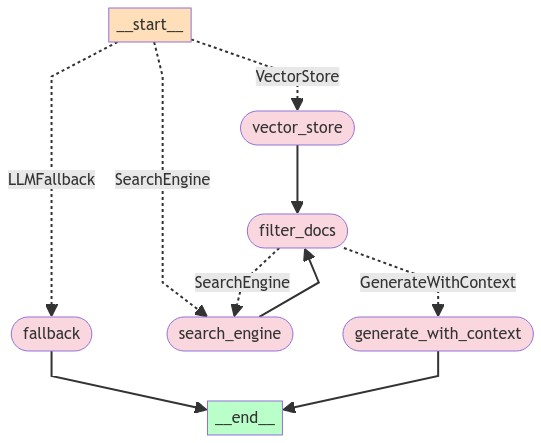

In [16]:
from io import BytesIO
from PIL import Image
from IPython.display import display

img = Image.open(BytesIO(plot))
display(img)

## Test the chatbot

* Question1: "What is the advantage of Bidirectional RNNs?"

In [68]:
response = app.invoke({"query": sample_queries[0]})

[router_node] ---Routing to VectorStore---
[vector_store] Retrieve 4 docs.
[filter_docs] Related documents len: 3
[generate_with_context] Generation: According to the provided context, the a...


In [63]:
response

{'query': 'What is the advantage of Bidirectional RNNs?',
 'generation': 'According to the provided context, the advantage of Bidirectional RNNs is that they can capture both the left and right contexts of an input at each point in time. This is achieved by combining the outputs of the forward and backward passes, allowing the model to use information from both the prior and future context to make predictions.',
 'documents': [Document(page_content='sequence from tto the end of the sequence.\nAbidirectional RNN (Schuster and Paliwal, 1997) combines two independentbidirectional\nRNN\nRNNs, one where the input is processed from the start to the end, and the other from\nthe end to the start. We then concatenate the two representations computed by the\nnetworks into a single vector that captures both the left and right contexts of an input\nat each point in time. Here we use either the semicolon ”;” or the equivalent symbol\n⊕to mean vector concatenation:\nht= [hf\nt;hb\nt]\n=hf\nt⊕hb\nt (

* Answer:

In [64]:
Markdown(response["generation"])

According to the provided context, the advantage of Bidirectional RNNs is that they can capture both the left and right contexts of an input at each point in time. This is achieved by combining the outputs of the forward and backward passes, allowing the model to use information from both the prior and future context to make predictions.

* Question2: "What is the differences between a stack and a queue."

In [65]:
response = app.invoke({"query": sample_queries[1]})

[router_node] ---Routing to SearchEngine---
[search_engine] Retrieve 5 webpages.
[filter_docs] Related documents len: 3
[generate_with_context] Generation: Based on the provided context, here are ...


In [66]:
response

{'query': 'What is the differences between a stack and a queue.',
 'generation': 'Based on the provided context, here are the differences between a stack and a queue:\n\n* A stack follows the Last In First Out (LIFO) principle, whereas a queue follows the First In First Out (FIFO) principle.\n* In a stack, elements are added and removed from the same end (the top), whereas in a queue, there are two ends, REAR and FRONT, for insertion and deletion respectively.\n* In a stack, you can add or remove elements only from one end called the top, whereas in a queue, there are two separate ends for insertion and deletion.\n\nNote that the context does not provide more detailed information about the differences in mechanism, structure, implementation, and variants between stacks and queues, as mentioned in the third document.',
 'documents': [Document(page_content='Key Differences Between Stack and Queue. Here is a table that highlights the key differences between stack and queue data structures

* Answer:

In [67]:
Markdown(response["generation"])

Based on the provided context, here are the differences between a stack and a queue:

* A stack follows the Last In First Out (LIFO) principle, whereas a queue follows the First In First Out (FIFO) principle.
* In a stack, elements are added and removed from the same end (the top), whereas in a queue, there are two ends, REAR and FRONT, for insertion and deletion respectively.
* In a stack, you can add or remove elements only from one end called the top, whereas in a queue, there are two separate ends for insertion and deletion.

Note that the context does not provide more detailed information about the differences in mechanism, structure, implementation, and variants between stacks and queues, as mentioned in the third document.

* Question3: "Who is the president of United States?"

In [69]:
response = app.invoke({"query": sample_queries[2]})

[router_node] ---No tool called---
[fallback] Generation: I'm happy to help! However, I must infor...


In [70]:
response

{'query': 'Who is the president of United States?',
 'generation': "I'm happy to help! However, I must inform you that my expertise lies within the domains of Natural Language Processing and Computer Science. I'm not designed to provide information on general knowledge or current events, including the president of the United States.\n\nIf you have any questions or topics related to NLP or Computer Science, I'd be more than happy to assist you!"}

In [71]:
Markdown(response["generation"])

I'm happy to help! However, I must inform you that my expertise lies within the domains of Natural Language Processing and Computer Science. I'm not designed to provide information on general knowledge or current events, including the president of the United States.

If you have any questions or topics related to NLP or Computer Science, I'd be more than happy to assist you!